## Load Dependancies

In [2]:
!pip install -q langchain==0.0.219
!pip install -q sentencepiece==0.1.99
!pip install -q sentence-transformers==2.2.2
!pip install -q nltk==3.8.1
!pip install -q langchain-community
!pip install -q chromadb==0.3.26


!pip install 'transformers @ git+https://github.com/huggingface/transformers.git@831bc25d8fdb85768402f772cf65cc3d7872b211'
!pip install -q accelerate==0.27.2 peft==0.8.2 bitsandbytes==0.41.3 trl==0.4.7 

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.6.4 requires numpy<1.26,>=1.16.0, but you have numpy 1.26.4 which is incompatible.
ydata-profiling 4.6.4 requires pydantic>=2, but you have pydantic 1.10.15 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
preprocessing 0.1.13 requires nltk==3.2.4, but you have nltk 3.8.1 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 23.8.0 requires cubinlinker, which is not installed.
cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 23.8.0 requires ptxcompiler, which is not installed.
cuml

In [3]:
from langchain.document_loaders import TextLoader
from langchain.document_loaders import DirectoryLoader
from langchain.text_splitter import NLTKTextSplitter
import nltk
from langchain.embeddings import SentenceTransformerEmbeddings
from langchain.vectorstores import Chroma
from langchain import PromptTemplate
from langchain.document_loaders import WikipediaLoader
import pandas as pd
import os
import time
import torch
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
)
from peft import LoraConfig, PeftModel
import warnings
warnings.filterwarnings("ignore")

2024-05-04 16:45:32.162559: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-04 16:45:32.162660: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-04 16:45:32.274085: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Loading Data

In [4]:
loader = DirectoryLoader("/kaggle/input/lectures",
                            glob="*.txt",
                            show_progress=True,
                            loader_cls=TextLoader).load()

print(f"Loaded Files are: {len(loader)}")

100%|██████████| 16/16 [00:00<00:00, 149.40it/s]

Loaded Files are: 16


In [5]:
eval_df = pd.read_csv("/kaggle/input/eval-data-rag/NLP_App_Project_QuestionsData.csv",header = None)

In [6]:
eval_df.rename(columns={0: 'question'}, inplace=True)

In [7]:
eval_df

,question
0,How has the application of convolutional neura...
1,What role does the availability of large datas...
2,Can you discuss the interdisciplinary nature o...
3,How does the k-nearest neighbor classifier det...
4,What are the main differences between a non-pa...
5,Explain how linear classifiers could struggle ...
6,Why is it important to choose the right hyperp...
7,What is the purpose of using a loss function i...
8,Describe the differences between stochastic gr...
9,Explain how the histogram of oriented gradient...


In [8]:
document = [loader[i].page_content for i in range(len(loader))]

<BarContainer object of 16 artists>

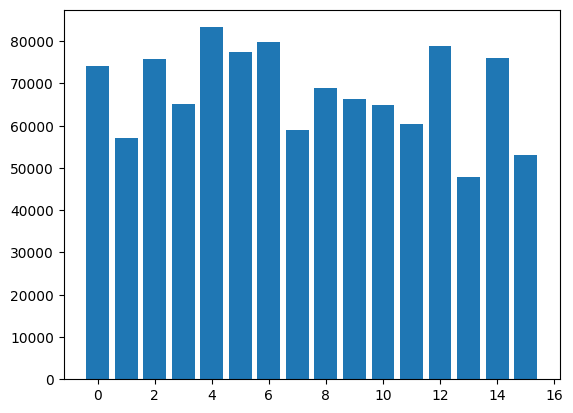

In [9]:
import matplotlib.pyplot as plt

lst = []
key = [i for i in range(16)]
for i in range(len(loader)):
    lst.append(len(loader[i].page_content))
    
plt.bar(key,lst)

## Chunking

In [20]:
nltk.download('punkt')

text_splitter = NLTKTextSplitter(chunk_size=500)

chunks = text_splitter.create_documents(document)

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [11]:
print(chunks[6].page_content)
print("-------------------------------")
print("\n")
print(f"Number of chunks are: {len(chunks)}")

So if there's, I guess if
there's no questions about administrative stuff then we'll
move on to course content.

Okay cool.

So recall from last time in lecture two, we were really talking about
the challenges of recognition and trying to hone in on this idea of a data-driven approach.

We talked about this idea
of image classification, talked about why it's hard,
there's this semantic gap between the giant grid of
numbers that the computer sees and the actual image that you see.
-------------------------------


Number of chunks are: 3380


## Embedding Model

In [12]:
model_name = "sentence-transformers/all-MiniLM-L6-v2"

embedding_llm = SentenceTransformerEmbeddings(model_name=model_name)

.gitattributes:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

data_config.json:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

train_script.py:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

In [13]:
docs_text = [ chunk.page_content for chunk in chunks ]
docs_embeddings = embedding_llm.embed_documents(docs_text)

Batches:   0%|          | 0/106 [00:00<?, ?it/s]

In [14]:
len(docs_embeddings)

3380

## Vector DataBase

In [15]:
save_to_dir = "/content/vector_chroma_db"

docs_ids = list(range(len(chunks)))
docs_ids = [ str(d) for d in docs_ids ]

vector_db = Chroma.from_documents(
                                chunks,
                                embedding_llm,
                                persist_directory=save_to_dir,
                                ids=docs_ids)

Batches:   0%|          | 0/106 [00:00<?, ?it/s]

## TinyLLama

In [14]:
model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

compute_dtype = getattr(torch, "float16")

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=False,
)


# # Load base model
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto"
)

model.config.use_cache = False
model.config.pretraining_tp = 1

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.padding_side = "right"

config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

In [15]:
from langchain_community.llms.huggingface_pipeline import HuggingFacePipeline


pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer = tokenizer,
    max_new_tokens=200,
    eos_token_id=tokenizer.eos_token_id,
)


llm = HuggingFacePipeline(pipeline=pipe)

## Testing Retrival

In [71]:
question = """
what is convolutional neural network and what means by receptive field"""

similar_docs = vector_db.similarity_search_with_score(question, k=7)

print(similar_docs[0][0].page_content)
similar_docs

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

That for this kind of normal convolution that we've seen many
times now in this class, our input might by four by four, our output might be four by four, and now we'll have this
three by three kernel and we'll take an inner product between, we'll plop down that kernel
at the corner of the image, take an inner product,
and that inner product will give us the value and the activation in the upper left hand
corner of our output.

And we'll repeat this
for every receptive field in the image.


[(Document(page_content="That for this kind of normal convolution that we've seen many\ntimes now in this class, our input might by four by four, our output might be four by four, and now we'll have this\nthree by three kernel and we'll take an inner product between, we'll plop down that kernel\nat the corner of the image, take an inner product,\nand that inner product will give us the value and the activation in the upper left hand\ncorner of our output.\n\nAnd we'll repeat this\nfor every receptive field in the image.", metadata={}),
  0.7775710821151733),
 (Document(page_content="And we'll repeat this\nfor every receptive field in the image.\n\nNow if we talk about strided convolution then strided convolution ends\nup looking pretty similar.\n\nHowever, our input is\nmaybe a four by four region and our output is a two by two region.\n\nBut we still have this idea of taking, of there being some three\nby three filter or kernel that we plop down in\nthe corner of the image, take an in

In [73]:
print(len(similar_docs))

7


## Inference

In [17]:
retrived = vector_db.similarity_search_with_score(question,k=1)
retrived_data = "\n".join([retrived[i][0].page_content for i in range(len(retrived))])

sys = f"""
Answer the next question using the provided context.
Context: {retrived_data}
"""

messages = [
    {"role": "system", "content": sys},
    {"role": "user", "content": "what is convolutional neural network and what means by receptive field"},
]

prompt = pipe.tokenizer.apply_chat_template(
        messages, 
        tokenize=False, 
        add_generation_prompt=True
)

out = llm(prompt)
out[len(prompt):]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The method `BaseLLM.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


'Convolutional Neural Network (CNN) is a type of deep learning algorithm that is designed to perform image classification and object detection tasks. It is a type of neural network that is inspired by the way the human brain processes visual information. CNNs use convolutional operations to extract features from the input image, which are then used to make predictions about the image.\n\nThe receptive field is a concept in neural networks that refers to the area of the input image that is used to compute the output. In CNNs, the receptive field is the area of the input image that is used to compute the output for a given layer. The receptive field is determined by the number of filters in the convolutional operation, which is a type of convolution.\n\nIn CNNs, the receptive field is used to extract features from the input image, which are then used to make predictions about the image. The receptive field is a critical component of CNN'

In [81]:
def answer_question(question, vector_db, llm, pipe):
    # Perform similarity search and retrieve data
    start_time = time.time()
    retrieved = vector_db.similarity_search_with_score(question, k=1)
    print(len(retrieved))
    retrieved_data = "\n".join([retrieved[i][0].page_content for i in range(len(retrieved))])

    # Prepare system message with the context
    start_time = time.time()
    system_message = f"""
    Answer the next question using the provided context.
    Context: {retrieved_data}
    """

    # Prepare messages for the language model
    messages = [
        {"role": "system", "content": system_message},
        {"role": "user", "content": question},
    ]

    # Create a prompt for the language model
    prompt = pipe.tokenizer.apply_chat_template(
        messages, 
        tokenize=False, 
        add_generation_prompt=True
    )

    # Generate an answer from the language model
    out = llm(prompt)
    answer = out[len(prompt):].strip()
    end_time = time.time()
    inference_time = end_time - start_time
    # Return the answer and the retrieved text
    return retrieved_data ,answer,inference_time

In [82]:
# eval_df[['retrieved_text', 'answer','inference_time']] = eval_df['question'].apply(lambda q: answer_question(q, vector_db, llm, pipe))

In [83]:
eval_df[['retrieved_text', 'answer','inference_time']] = None,None,None

In [90]:
eval_df["question"].iloc[17] = "How does batch normalization improve the training process of neural networks, and what are its main benefits?"

In [129]:
eval_df = pd.read_csv("/kaggle/working/rag_output.csv")

In [131]:
eval_df.drop("Unnamed: 0", inplace=True,axis=1)

In [92]:

for i in range(50):
    retrieved_text, answer, inference_time = answer_question(eval_df["question"].iloc[i], vector_db, llm, pipe)
    eval_df["retrieved_text"].iloc[i] = retrieved_text
    eval_df["answer"].iloc[i] = answer
    eval_df["inference_time"].iloc[i] = inference_time

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


In [97]:
eval_df.rename(columns={"inference_time": 'llm_inference_time',"answer":"llm_answer"}, inplace=True)

In [16]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-large")
model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-large", device_map="auto")

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [24]:
def answer_question_transformer(question, vector_db, model, tokenizer):
    # Perform similarity search and retrieve data
    start_time = time.time()
    retrieved = vector_db.similarity_search_with_score(question, k=1)
    print(len(retrieved))
    retrieved_data = "\n".join([retrieved[i][0].page_content for i in range(len(retrieved))])

    # Prepare system message with the context
    start_time = time.time()
    context = retrieved_data
    input_text ="Answer the next question using the provided context in 2 to 5 sentences."+ context + " " + question
    input_ids = tokenizer(input_text, return_tensors="pt").input_ids.to("cuda")
    outputs = model.generate(input_ids, max_length=400)
    answer = tokenizer.decode(outputs[0],skip_special_tokens=True)
    end_time = time.time()
    inference_time = end_time - start_time
    # Return the answer and the retrieved text
    return answer,inference_time

In [25]:
eval_df[[ 't5_answer','t5_inference_time']] = None,None

In [26]:
for i in range(50):
    answer, inference_time = answer_question_transformer(eval_df["question"].iloc[i], vector_db, model, tokenizer)
    eval_df["t5_answer"].iloc[i] = answer
    eval_df["t5_inference_time"].iloc[i] = inference_time

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1


In [28]:
eval_df["t5_answer"].loc[1]

'allowed us to work with higher capacity models and train these models to actually work quite well on real world problems'

In [29]:
eval_df.to_csv("/kaggle/working/rag_t5_output.csv",index=False)